# Implementing a Neural Network for CIFAR dataset
In this exercise, you should change H.W_1 to work on the CIFAR dataset.

CIFAR is a dataset that consists of 60,000 32x32 colour images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with 6000 images per class.

We will have the same components as were in the previous exercise:
- Loading the data and visualize some of the images
- Training the model. Instead of loading a pre-trained model, we will define a new very basic architecture.


## 1) Loading CIFAR dataset (10 points)

You should load the CIFAR dataset. You can use [the pytorch CIFAR tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). You should define a dictionary of ``dataloaders``. For now, no need to define pre-process to the data. 
Please create a dataloaders disctionary ``{'train','val'}``

You can use batch_size = 128

In [ ]:
import time
import copy
import torchvision
import torch
import random
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
BATCH_SIZE = 128

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

image_set = {
        'train': torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform),
        'val': torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)}

dataloaders = {phase: torch.utils.data.DataLoader(image_set[phase], 
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=phase=='train', 
                                                 num_workers=2)
for phase, data in image_set.items()
}
CLASSES = image_set['train'].classes


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
dataset_sizes = {phase: len(image_set[phase]) for phase in ['train', 'val']}

# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**If you manage to load the CIFAR data correctly, you should run the next three cells and see some of the images.**

## Visualize some of the training images

In this dataset the size of the images are 32x32. 

It is important to visualize the data in order to see that we load them correctly (maybe we need to divide by 255? should we make channel permutations?) 

The code below was taken from H.W_1 school solution

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

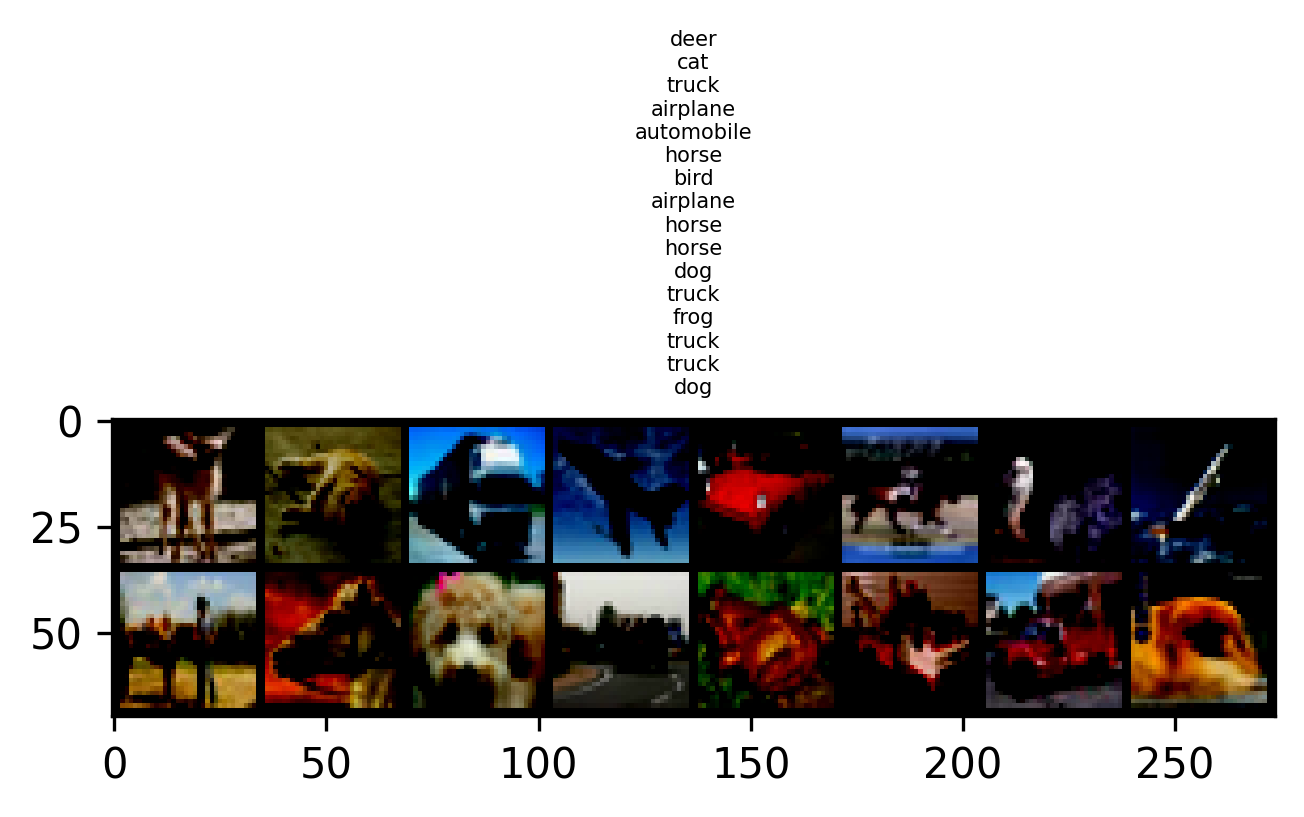

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([CLASSES[x] for x in classes]))

## A 2-layer Neural Network

We will define 2-fully-connected-layer network using Sequential module. We have two hidden layers: the first one has 100 neurons and the second one has 20 neurons. The last layer is the output that has 10 elements.

Please pay attention that we take images after flattening (line 15 below).

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )

        self.losses = {'train': [], 'val': [] }
        self.accuracy = {'train': [], 'val': [] }


    def forward(self, x):
        x = self.flatten(x)
        probs = self.linear_relu_stack(x)
        return probs

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


**Pay attention, when you train a network and change something in the parameters, the data, data loaders, image transform, optimizations and more...you should load the model again so it will start from random weights and not from the last training**.

**You should run again the line** ``model = NeuralNetwork().to(device)``


The next two cells (defining the loss and the training loop) were copied from last exercise. 


In [ ]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            model.losses[phase].append(epoch_loss)
            model.accuracy[phase].append(epoch_acc.cpu().item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = train_model(model, 
                    dataloaders,
                    criterion, 
                    optimizer_ft, 
                    exp_lr_scheduler,
                    num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 2.1761 Acc: 0.2163
val Loss: 2.0313 Acc: 0.2807

Epoch 1/9
----------
train Loss: 1.9433 Acc: 0.3074
val Loss: 1.8683 Acc: 0.3397

Epoch 2/9
----------
train Loss: 1.8286 Acc: 0.3548
val Loss: 1.7796 Acc: 0.3720

Epoch 3/9
----------
train Loss: 1.7506 Acc: 0.3818
val Loss: 1.7114 Acc: 0.4009

Epoch 4/9
----------
train Loss: 1.6886 Acc: 0.4028
val Loss: 1.6588 Acc: 0.4184

Epoch 5/9
----------
train Loss: 1.6405 Acc: 0.4201
val Loss: 1.6201 Acc: 0.4341

Epoch 6/9
----------
train Loss: 1.6021 Acc: 0.4328
val Loss: 1.5887 Acc: 0.4456

Epoch 7/9
----------
train Loss: 1.5761 Acc: 0.4429
val Loss: 1.5814 Acc: 0.4456

Epoch 8/9
----------
train Loss: 1.5718 Acc: 0.4450
val Loss: 1.5782 Acc: 0.4460

Epoch 9/9
----------
train Loss: 1.5683 Acc: 0.4471
val Loss: 1.5754 Acc: 0.4460

Training complete in 2m 31s
Best val Acc: 0.446000


You can continue after you see your model learns something (the training loss is decreasing).

# 2) Losses in Pytorch (10 points)

Now that you managed to run the training loop, let's understand the loss definition. PyTorch provides losses such as cross-entropy loss (`nn.CrossEntropyLoss`) that has just been used. You'll usually see the loss assigned to `criterion`. For classification problems such as CIFAR, we use the softmax function to predict class probabilities. With a softmax output, we need to use cross-entropy as the loss. To actually calculate the loss, we first define the criterion, then pass in it the output of your network and the correct labels.

*Important note!* Look at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

It means that we need to pass in `nn.CrossEntropyLoss` the raw output of our network into, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities, which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually better to avoid doing calculations with probabilities, and generally we use log-probabilities.

**Exercise:** Change the network above to output the log-softmax and calculate the loss using the negative log-likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.


In [ ]:
class NeuralNetworkLogSoftmax(NeuralNetwork):
    def __init__(self):
        super(NeuralNetworkLogSoftmax, self).__init__()
        self.linear_relu_stack.add_module("LogSoftmax", torch.nn.LogSoftmax(dim=1))


In [ ]:
model = NeuralNetworkLogSoftmax().to(device)
criterion = nn.NLLLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

model = train_model(model, 
                    dataloaders,
                    criterion, 
                    optimizer_ft, 
                    exp_lr_scheduler,
                    num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 2.1875 Acc: 0.1862
val Loss: 2.0620 Acc: 0.2516

Epoch 1/9
----------
train Loss: 1.9687 Acc: 0.2990
val Loss: 1.8871 Acc: 0.3343

Epoch 2/9
----------
train Loss: 1.8398 Acc: 0.3539
val Loss: 1.7894 Acc: 0.3713

Epoch 3/9
----------
train Loss: 1.7588 Acc: 0.3792
val Loss: 1.7224 Acc: 0.3937

Epoch 4/9
----------
train Loss: 1.7009 Acc: 0.4000
val Loss: 1.6732 Acc: 0.4093

Epoch 5/9
----------
train Loss: 1.6555 Acc: 0.4172
val Loss: 1.6340 Acc: 0.4234

Epoch 6/9
----------
train Loss: 1.6168 Acc: 0.4304
val Loss: 1.6046 Acc: 0.4346

Epoch 7/9
----------
train Loss: 1.5919 Acc: 0.4418
val Loss: 1.5965 Acc: 0.4375

Epoch 8/9
----------
train Loss: 1.5878 Acc: 0.4420
val Loss: 1.5933 Acc: 0.4388

Epoch 9/9
----------
train Loss: 1.5843 Acc: 0.4433
val Loss: 1.5903 Acc: 0.4403

Training complete in 2m 26s
Best val Acc: 0.440300


# 3) Debug the training (15 points)
With the default parameters we provided above, you should get a validation accuracy of about 0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization. 

**Exersice:** Write this visualization here.
(you can copy your solution from last exercies)


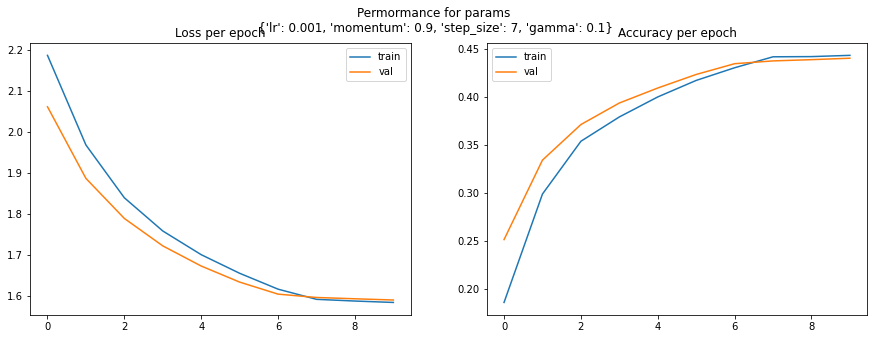

In [ ]:
import pandas as pd

DEFAULT_PARAMS = {**dict(lr=0.001, momentum=0.9), **dict(step_size=7, gamma=0.1)}


def plot_performance(model, params=DEFAULT_PARAMS):
    
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    fig.suptitle(f'Permormance for params \n{params}')
    pd.DataFrame(model.losses).plot(ax=axs[0]).set(title='Loss per epoch')
    pd.DataFrame(model.accuracy).plot(ax=axs[1]).set(title='Accuracy per epoch')


plot_performance(model)

# 4) Tune your hyperparameters (50 points)

**What's wrong?**. Looking at the loss above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy. 

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including *hidden layer size, learning rate, numer of training epochs, and adding l2 or l1 regularization to the cross entropy loss*. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [ ]:
class NeuralNetworkHPT(nn.Module):
    def __init__(self, dropout_rate=0.2, hidden_depth=4, layer_pop=100):
        super(NeuralNetworkHPT, self).__init__()
        self.flatten = nn.Flatten()
        
        repeating = [
            nn.Dropout(dropout_rate),
            nn.Linear(layer_pop, layer_pop),
            nn.ReLU(),
            ] * hidden_depth

        self.linear_relu_stack = nn.Sequential(
            
            nn.Linear(32*32*3, layer_pop),
            nn.ReLU(),

            *repeating,

            nn.Linear(layer_pop , layer_pop // 2),


            nn.Linear(layer_pop // 2, 10),
        )

        self.losses = {'train': [], 'val': [] }
        self.accuracy = {'train': [], 'val': [] }


    def forward(self, x):
        x = self.flatten(x)
        probs = self.linear_relu_stack(x)
        return probs

    

Epoch 0/9
----------
train Loss: 2.0172 Acc: 0.2676
val Loss: 1.7638 Acc: 0.3652

Epoch 1/9
----------
train Loss: 1.6962 Acc: 0.3934
val Loss: 1.5912 Acc: 0.4401

Epoch 2/9
----------
train Loss: 1.5800 Acc: 0.4372
val Loss: 1.5044 Acc: 0.4644

Epoch 3/9
----------
train Loss: 1.5021 Acc: 0.4675
val Loss: 1.4439 Acc: 0.4888

Epoch 4/9
----------
train Loss: 1.4445 Acc: 0.4896
val Loss: 1.4068 Acc: 0.4996

Epoch 5/9
----------
train Loss: 1.3978 Acc: 0.5065
val Loss: 1.3846 Acc: 0.5108

Epoch 6/9
----------
train Loss: 1.3619 Acc: 0.5196
val Loss: 1.3541 Acc: 0.5192

Epoch 7/9
----------
train Loss: 1.2873 Acc: 0.5461
val Loss: 1.3227 Acc: 0.5297

Epoch 8/9
----------
train Loss: 1.2722 Acc: 0.5484
val Loss: 1.3189 Acc: 0.5347

Epoch 9/9
----------
train Loss: 1.2624 Acc: 0.5540
val Loss: 1.3177 Acc: 0.5340

Training complete in 2m 28s
Best val Acc: 0.534700
{'dropout_rate': 0.2, 'hidden_depth': 1, 'layer_pop': 175} {'momentum': 0.9, 'lr': 0.005, 'weight_decay': 1e-05}


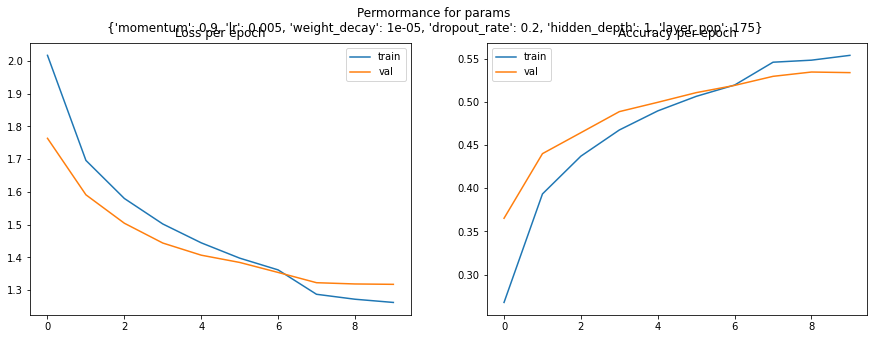

In [ ]:
DEFAULT_OPTIMIZER = dict(lr=0.001, momentum=0.9)
DEFAULT_SCHEDULER = dict(step_size=7, gamma=0.1)
DEFAULT_MODEL = dict(dropout_rate=0.2, hidden_depth=4, layer_pop=100)

import os, sys
from itertools import product


def try_some_hyper_stuff(dataloaders, optimizer_params=DEFAULT_OPTIMIZER, scheduler_params=DEFAULT_SCHEDULER,
                         model_params=DEFAULT_MODEL ,epochs=10):

    model = NeuralNetworkHPT(**model_params).to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer_ft = optim.SGD(model.parameters(), **optimizer_params)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, **scheduler_params)
    
    model = train_model(model, 
                        dataloaders,
                        criterion, 
                        optimizer_ft, 
                        exp_lr_scheduler,
                        num_epochs=epochs)
    print(model_params, optimizer_params)

    plot_performance(model, params=dict(**optimizer_params, 
                                        **model_params,))
    
    return model

learning_rates = [0.005]
weight_decays = [1e-5]
dropout_rates = [0.2]
hidden_depths = [1]
layer_pops = [175]

for lr, wd, dor, hd, lp in product(learning_rates, weight_decays, dropout_rates, hidden_depths, layer_pops):
    params = dict(momentum=0.9, lr=lr, weight_decay=wd)
    model_params = dict(dropout_rate=dor, hidden_depth=hd, layer_pop=lp)
    try_some_hyper_stuff(dataloaders, epochs=10, optimizer_params=params, model_params=model_params)
plt.show()

# {'dropout_rate': 0.2, 'hidden_depth': 1, 'layer_pop': 175} {'momentum': 0.9, 'lr': 0.005, 'weight_decay': 1e-05} # 1 layer of narrowing down (//2) (0.5347)

# Interview Question (15 points)

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

*Your answer*: 

> 1, 3

*Your explanation:*

> 1. The training data doesn't fully capture the complexity of the real world, as represented by the testing data. In that case, adding more data could help cover cases that are not sufficiently represented at the moment. 
> 2. Model overfits, adding more hidden units will enable more overfitting.
> 3. The model overfits, meaning it learned the training data too closely and now fails to generalize. In this case, regularization could help. 

>